#  Fit to analyze data from www.data.gouv.fr

**Note:** This is a Jupyter notebook which is also available as its executable export as a Python 3 script (therefore with automatically generated comments).

# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
print("For now, reduce python warnings, I will look into this later")

For now, reduce python warnings, I will look into this later


In [2]:
import os, sys

import math
import pandas            as PAN
import numpy             as NP
import numpy.random      as RAND
import scipy.stats       as STATS
from scipy import sparse
from scipy import linalg
from scipy import integrate
from scipy import optimize

# Better formatting functions; ensure that this work as script
from IPython.display import display, HTML
from IPython import get_ipython

### Import my own modules
The next cell attempts to give user some information if things improperly setup.
Intended to work both in Jupyter and when executing the Python file directly.

In [3]:
if not get_ipython() is None and os.path.abspath("../source/") not in sys.path:
    sys.path.append(os.path.abspath("../source/"))
try:
    from lib.utilities     import *
    from lib.figureHelpers import *
    from lib.DataMgrJSON   import *
    from lib.basicUtils    import toDict
    import lib.basicDataCTE as DCTE
    import lib.epidemioModels as EPIM 
except Exception as err:
    print("Could not find library 'lib' with contents 'DataGouvFr' ")
    if get_ipython() is None:
        print("Check the PYTHONPATH environment variable which should point to 'source' wich contains 'lib'")
    else:
        print("You are supposed to be running in JupySessions, and '../source/lib' should exist")
    raise err

Loaded lib
For now, reduce python warnings, I will look into this later


In [4]:
checkSetup(chap="Fit01")
ImgMgr = ImageMgr(chapdir="Fit01")

# Models and Synthetic data
I thought of using either: 
- the methods exposed in Parameter Estimation and Uncertainty Quantification for an
Epidemic Model by  A. Capaldi et al.
- the method used in the tutorial 'Fitting Epidemic Models to Data' by J.H.Jones (http://web.stanford.edu/class/earthsys214/notes/fit.html) (with code in R)

Eventually, I turned to an expanded SEIR model inspired by the paper 
"**Epidemic analysis of COVID-19 in China by dynamical modeling**"
(*arxiv:2002.06563V1*), which includes *quarantined* and *insusceptible* categories. 
It includes fitted parameters for several areas in China.

The other references I have collected are more sophisticated!e 

With respect to data, I am using here data generated by the model under study with a different
parameter set, sometimes with the addition of random noise to try figuring out **sensitivity**.

Fitting to real data is being explored in a different notebook: file:FIT-Data-FromGouv.ipynb

## Redo the Stanford / Jones example
Moving from *R* to *python*

### Simple SIR model

$$
\begin{eqnarray}
\frac{ds}{dt}&=& -\beta s i
\\
\frac{di}{dt}&=&  \beta s i - \nu i
\\
\frac{dr}{dt}&=&  \nu i
\\
\end{eqnarray}
$$

In [5]:
def SIRFn (y, t, params):
     s, i, r =  y
     beta, nu = params
     dydt     = (- beta * s * i , beta * s * i - nu *i , nu * i)
     return dydt

In [6]:
t0 = 0
tF = 10
tDelta = 0.1
t = NP.arange(t0, tF, tDelta)

i0 = 0.1
s0 = 1 - i0
r0 = 0
y0 = (s0 , i0, r0 )

params = (1,1)

In [7]:
psoln = integrate.odeint(SIRFn, y0, t, args=(params,))

In [8]:
PLT.figure(figsize=(5,5))
solDF=PAN.DataFrame(psoln)
solDF.columns = ("Susceptibles", "Infected", "Removed")
solDF.index = t

<Figure size 360x360 with 0 Axes>

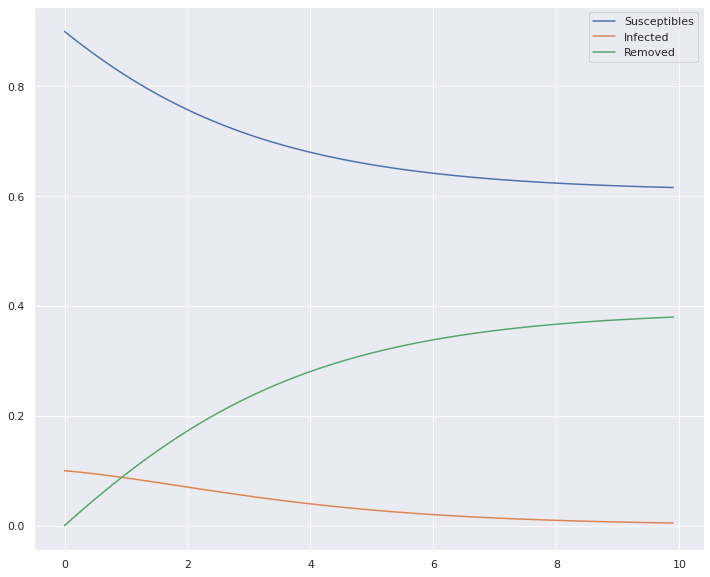

In [9]:
PLT.plot(solDF)
PLT.legend(labels=solDF.columns)

### Simple SEIR Model
Here 
s = susceptibles
e = exposed
i = infected
r = removed

$$
\begin{eqnarray}
\frac{ds}{dt}&=& -\beta s i + \lambda - \mu s
\\
\frac{de}{dt}&=&  \beta s i - (\mu + \kappa) e
\\
\frac{di}{dt}&=&  \kappa e - (\gamma + \mu) i
\\
\frac{dr}{dt}&=&  \gamma i - \mu r
\\
\end{eqnarray}
$$

In [10]:
def SEIRFn (y, t, params):
     s, e, i, r            =  y
     beta, lamb, mu, kappa, gamma =  params
     dydt     = (- beta * s * i + lamb - mu * s, 
                 beta * s * i - ( mu + kappa) * e , 
                 kappa * e - (gamma+mu)*i, 
                 gamma * i - mu * r)
     return dydt

In [11]:
t0 = 0
tF = 200
tDelta = 0.1
t = NP.arange(t0, tF, tDelta)

i0 = 0
e0 = 1.0e-6
r0 = 0
s0 = 1 - (i0 + e0 + r0) 
y0 = (s0 , e0, i0, r0 )

params = (3/8, 0.015/365, 0.012/365, 0.5, 0.2)

In [12]:
psoln = integrate.odeint(SEIRFn, y0, t, args=(params,))

In [13]:
PLT.figure(figsize=(5,5))
solDF=PAN.DataFrame(psoln)
solDF.columns = ("Susceptibles","Exposed","Infected","Removed")
solDF.index = t

<Figure size 360x360 with 0 Axes>

Saving figure FIG001


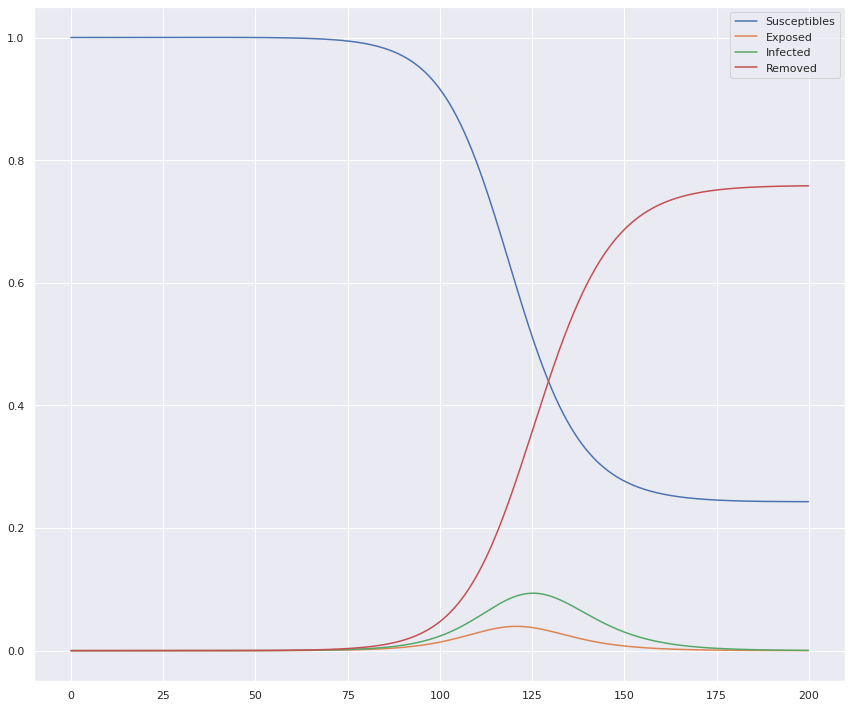

In [14]:
PLT.plot(solDF)
PLT.legend(labels=solDF.columns)
ImgMgr.save_fig("FIG001")

### More models

An expanded SEIR model is used in the paper "Epidemic analysis of COVID-19 in China by dynamical modeling"
(arxiv:2002.06563V1), which includes *quarantined* and *insusceptible* categories. They publish fitted parameters for several areas in China.

- s: susceptibles
- p: insusceptibles
- e: exposed
- i: infected
- q: quarantined
- r: recovered
- d: dead

$$
\begin{eqnarray}
  \frac{ds}{dt}&=&  -\beta \frac{s i}{N} - \alpha s 
  \\
  \frac{de}{dt}&=&  \beta \frac{s i}{N} - \gamma e 
  \\
  \frac{di}{dt}&=&  \gamma e - \delta i 
  \\
  \frac{dq}{dt}&=&  \delta i - (\lambda + \kappa) q 
  \\
  \frac{dr}{dt}&=&  \lambda  q 
  \\
  \frac{dd}{dt}&=&  \kappa q 
  \\
  \frac{dp}{dt}&=&  \alpha s 
  \\
\end{eqnarray}
$$

In [15]:
def SEIRXFn (y, t, params):
     s, e, i, q, r, d, p  =  y
     beta, alpha, delta, lamb, kappa, gamma =  params
     dydt     = (- beta * s * i - alpha * s,          # s 
                 beta * s * i - gamma * e ,           # e
                 gamma * e - delta*i,                 # i
                 delta * i - ( lamb + kappa ) * q,    # q
                 lamb * q,                            # r
                 kappa * q,                           # d
                 alpha * s                            # p 
                )
     return dydt

In [16]:
t0 = 0
tF = 200
tDelta = 0.1
t = NP.arange(t0, tF, tDelta)

i0 = 1.0e-3             # infected
e0 = 1.0e-3             # exposed
r0 = 0                  # recovered
s0 = 1 - (i0 + e0 + r0) # susceptibles
q0 = 0                  # quarantined
d0 = 0                  # dead
p0 = 0                  # insusceptibles

y0 = (s0 , e0, i0, q0, r0, d0, p0 )

params = (1,       # beta          rate of exposition (in prop of susceptibles meeting infected)
          10.0e-3,   # alpha         rate of susceptibles becoming insusceptible
          100.0e-3,  # delta         inverse average quarantine time
          0.1,        # lambda        recovery/cure rate
          2.0e-2,      # kappa        mortality rate
          0.05        # gamma         inverse average latent time 
         )

In [17]:
psoln = integrate.odeint(SEIRXFn, y0, t, args = (params,))

In [18]:
PLT.figure(figsize=(5,5))
solDF=PAN.DataFrame(psoln)
solDF.columns = ("susceptible", "exposed","infected", "quarantined", "recovered", "dead", "insusceptible")
solDF.index = t

<Figure size 360x360 with 0 Axes>

In [19]:
styles = {"susceptible":"b", 
          "exposed":"r",
          "infected":"ro", 
          "quarantined":"p", 
          "recovered":"yo-", 
          "dead":"b--", 
          "insusceptible":"g"
         }

Saving figure FIG002


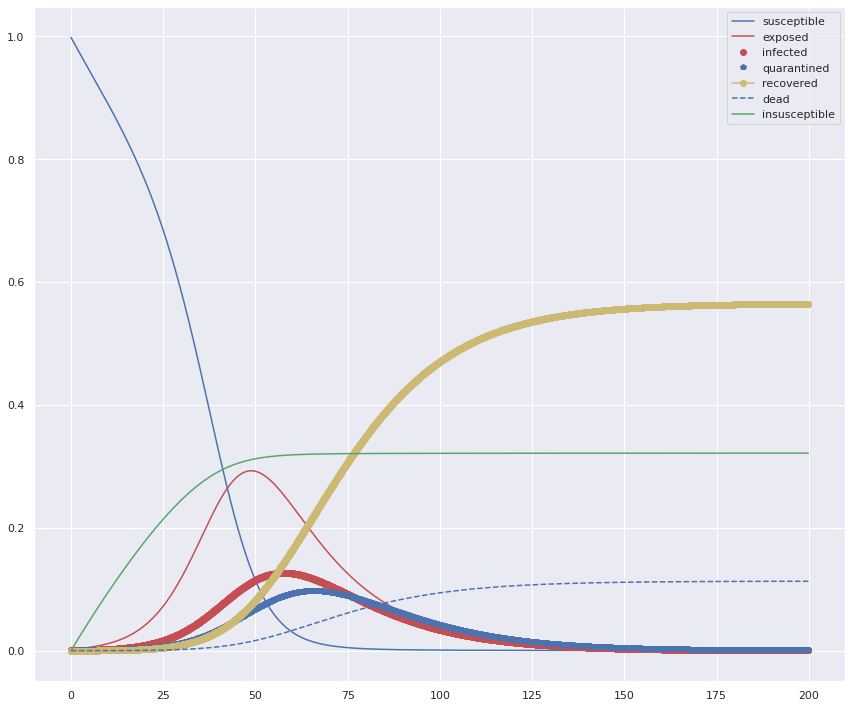

In [20]:
solDF.plot(style=styles)
PLT.legend(labels=solDF.columns)
ImgMgr.save_fig("FIG002")

Making some parameters time dependent: this better fits the cited paper, and also permits to take into account changes in regulation or behaviour (like social distancing)

In [21]:
class SEIRYFn (object):
    def __init__(self, params):
      self.beta, self.alpha, self.delta, self.lamb, self.kappa, self.gamma = params
    def __call__(self, y, t):
     s, e, i, q, r, d, p  =  y
     dydt     = (- self.beta * s * i - self.alpha * s,          # s 
                   self.beta * s * i - self.gamma * e ,           # e
                   self.gamma * e    - self.delta*i,                 # i
                   self.delta * i    - ( self.lamb(t) + self.kappa(t) ) * q,    # q
                   self.lamb(t) * q,                            # r
                   self.kappa(t) * q,                           # d
                   self.alpha * s                            # p 
                )
     return dydt

In [22]:
t0 = 0
tF = 200
tDelta = 0.1
t = NP.arange(t0, tF, tDelta)

i0 = 1.0e-3             # infected
e0 = 1.0e-3             # exposed
r0 = 0                  # recovered
s0 = 1 - (i0 + e0 + r0) # susceptibles
q0 = 0                  # quarantined
d0 = 0                  # dead
p0 = 0                  # insusceptibles

y0 = (s0 , e0, i0, q0, r0, d0, p0 )

def lambFn(t):
    if t <20:
        return 0.1
    else:
        return 0.2
    
def kappaFn(t):
    if t<30:
        return 2.0e-2
    else:
        return 1.0e-2

params = (1,       # beta          rate of exposition (in prop of susceptibles meeting infected)
          10.0e-3,   # alpha         rate of susceptibles becoming insusceptible
          100.0e-3,  # delta         inverse average quarantine time
          lambFn,        # lambda(t)        recovery/cure rate
          kappaFn,      # kappa(t)        mortality rate
          0.05        # gamma         inverse average latent time 
         )


In [23]:
psoln = integrate.odeint( SEIRYFn(params), y0, t )

In [24]:
PLT.figure(figsize=(5,5))
solDF=PAN.DataFrame(psoln)
solDF.columns = ("susceptible", "exposed","infected", "quarantined", "recovered", "dead", "insusceptible")
solDF.index = t

<Figure size 360x360 with 0 Axes>

In [25]:
styles = {"susceptible":"b", 
          "exposed":"r",
          "infected":"ro", 
          "quarantined":"p", 
          "recovered":"yo-", 
          "dead":"b--", 
          "insusceptible":"g"
         }

Saving figure FIG003


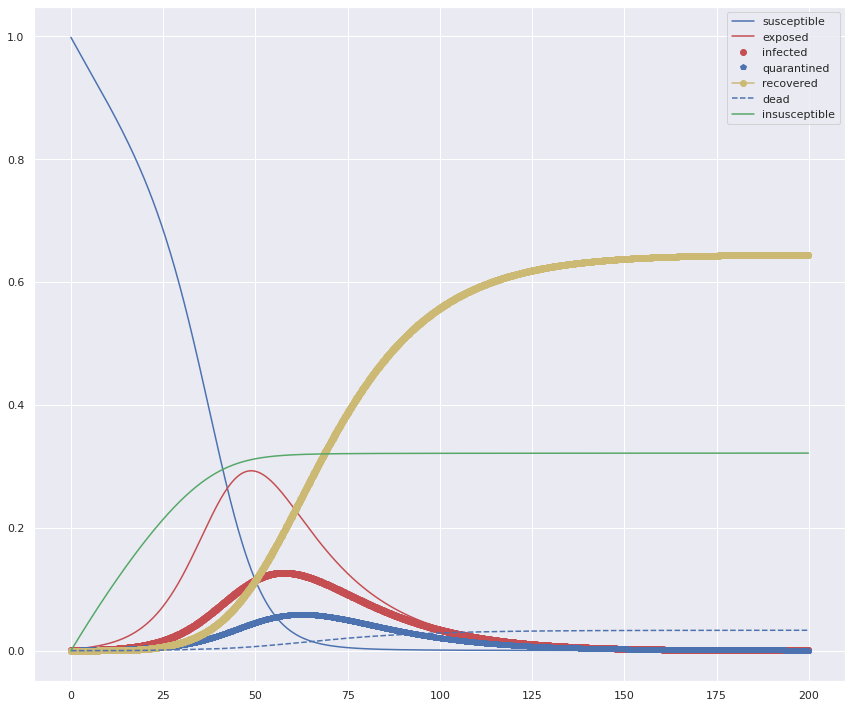

In [26]:
solDF.plot(style=styles)
PLT.legend(labels=solDF.columns)
ImgMgr.save_fig("FIG003")

### Now see if we can fit something?
First, lets adapt the <FONT COLOR="BLUE">model constants</FONT> to fit the paper's ("Epidemic analysis of COVID-19 in China by dynamical modeling" (arxiv:2002.06563V1)) data concerning Wuhan (pages 5,9). The following is quite freely adapted, 
notably when defining `lambFn` and `kappaFn`...

In [27]:
t0 = 0
tF = 100
tDelta = 1
t = NP.arange(t0, tF, tDelta)

i0 = 389/14.0e6         # infected   Wuhan in paper
e0 = 318/14.0e6         # exposed
r0 = 0                  # recovered
s0 = 1 - (i0 + e0 + r0) # susceptibles
q0 = 0                  # quarantined
d0 = 0                  # dead
p0 = 0                  # insusceptibles

y0 = (s0 , e0, i0, q0, r0, d0, p0 )

def lambFn(t):          # estimated dates for change in policy/efficiency
    if t <20:
        return 0.01
    else:
        return 0.02
    
def kappaFn(t):          # estimated dates for change in policy/efficiency
    if t<30:
        return 3.0e-2
    else:
        return 1.0e-2

params = (1,       # beta          rate of exposition (in prop of susceptibles meeting infected)
          0.085,   # alpha         rate of susceptibles becoming insusceptible
          1/7.4,  # delta         inverse average quarantine time
          lambFn,        # lambda(t)        recovery/cure rate
          kappaFn,      # kappa(t)        mortality rate
          0.5        # gamma         inverse average latent time 
         )


In [28]:
psoln, psolDict = integrate.odeint( SEIRYFn(params), y0, t, full_output = True)

In [29]:
PLT.figure(figsize=(5,5))
solDF=PAN.DataFrame(psoln)
solDF.columns = ("susceptible", "exposed","infected", "quarantined", "recovered", "dead", "insusceptible")
solDF.index = t

<Figure size 360x360 with 0 Axes>

In [30]:
styles = {"susceptible":"b", 
          "exposed":"r",
          "infected":"ro", 
          "quarantined":"p", 
          "recovered":"yo-", 
          "dead":"b--", 
          "insusceptible":"g"
         }

In [31]:
solDF.columns

Index(['susceptible', 'exposed', 'infected', 'quarantined', 'recovered',
       'dead', 'insusceptible'],
      dtype='object')

Saving figure FIG004


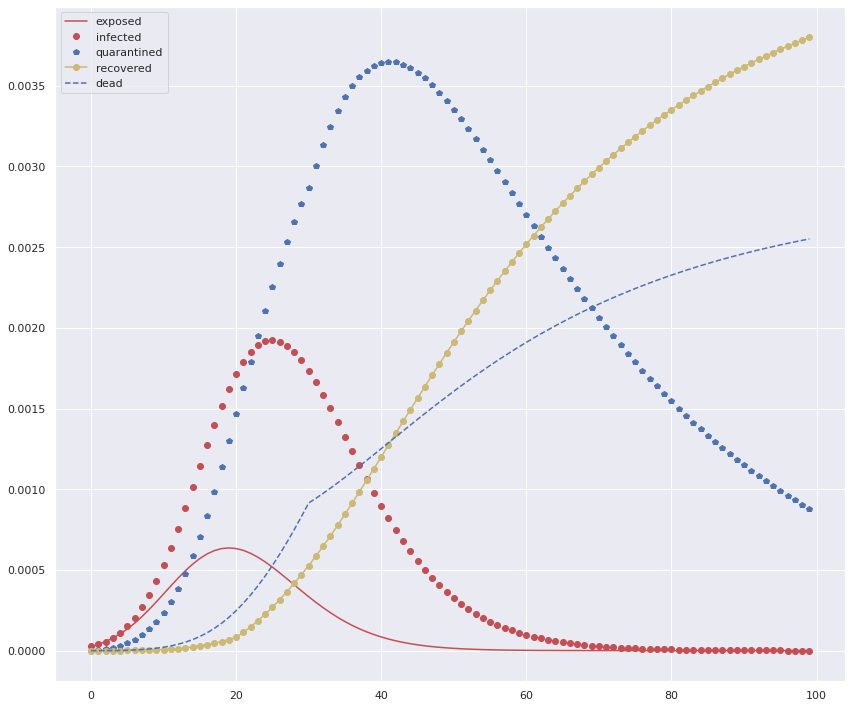

In [32]:
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = solDF.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG004")

Check the extended information available from the EDO solver.

In [33]:
tsu=psolDict["hu"]
print(f"For this ODE solution: time steps:{len(tsu)}, max={tsu.max()}, min={tsu.min()}")

For this ODE solution: time steps:99, max=2.4102451293548173, min=0.0053446254396790046


Saving figure FIG005


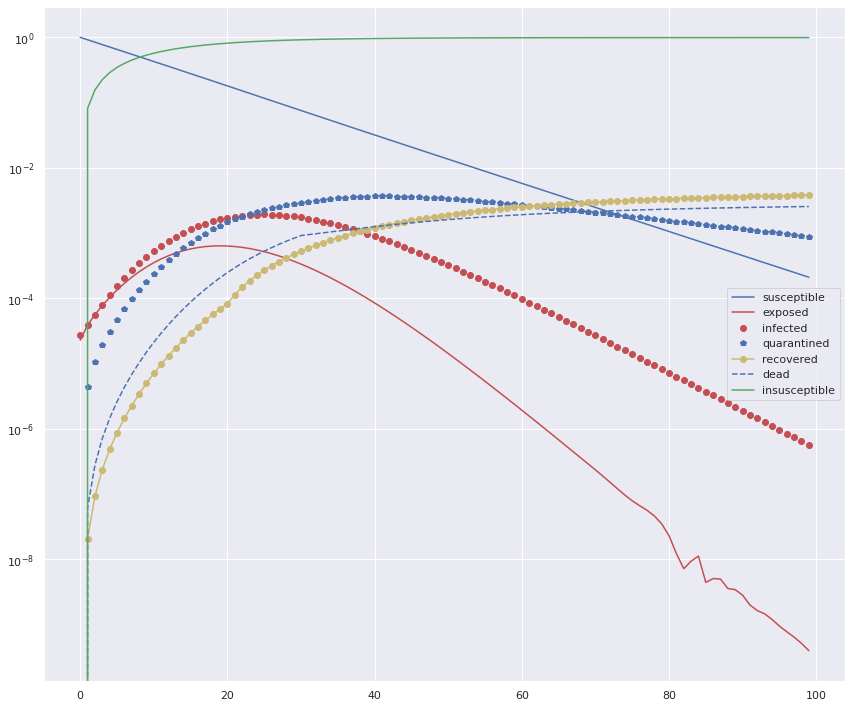

In [34]:
ax = solDF.plot(style=styles)
PLT.legend(labels=solDF.columns)
ax.set_yscale('log')
ImgMgr.save_fig("FIG005")

Now we need to fix an optimization criterion, which will be a related to statistical error (1-likelyhood).
This is explained in the book "The Elements of Statistical Learning" by T.Hastie & al. p 265), and finally yields a  square errof formula (up to multiplicative constant):
$$
 \sum_{i=1}^{N} log_{\theta}(z_i) =  -\frac{1}{2}\ \sum_{i=1}^{N} \frac{({z_i}-\mu)^2}{\sigma^2}  
$$

### Single parameter fit

We start with a simple proposition, to make sure everything works: identifying a single parameter, chosen to be $\beta$ (rate of exposition: proportion of susceptibles becoming infected )

The first attempt at fitting parameters will be with the output obtained from this run with added noise; this will permit to experiment with various model parameters and see if the solver can figure out  the original

In [35]:
recov=solDF["recovered"]
dead =solDF["dead"]

In [36]:
recov.describe()

count    100.000000
mean       0.001793
std        0.001397
min        0.000000
25%        0.000258
50%        0.001878
75%        0.003158
max        0.003800
Name: recovered, dtype: float64

This mode of perturbation is more realistic since it is increasing, but this implies it does not have 0 mean!

In [37]:
def growNoise(scale=1, size=(12,)):
     x =  NP.random.normal(scale=scale, size=size)
     y = NP.maximum(x,0)
     return NP.cumsum(y)

In [38]:
deadRand = dead + growNoise(scale=dead.max()*0.001, size=dead.shape)
recovRand = recov + growNoise(scale=recov.max()*0.001, size=recov.shape)

Saving figure FIG006


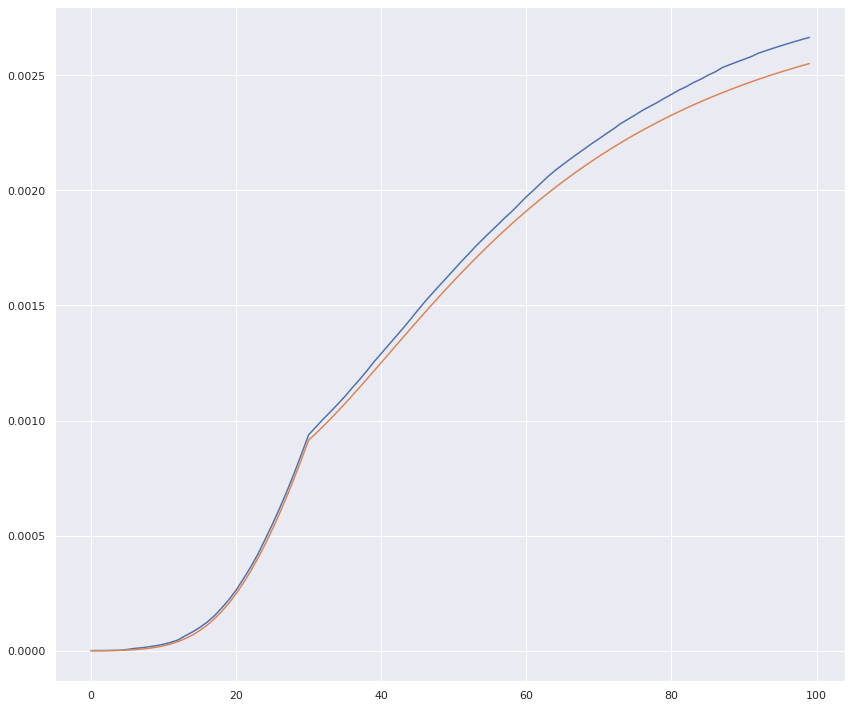

In [39]:
PLT.plot(deadRand)
PLT.plot(dead)
ImgMgr.save_fig("FIG006")

Now, compute the error function (see T.Hastie & al. p 265). The likelihood (opposite of error) is given by (up to constant factor)

$$
 \sum_{i=1}^{N} log_{\theta}(z_i) =  -\frac{1}{2}\ \sum_{i=1}^{N} \frac{({z_i}-\mu)^2}{\sigma^2}  
$$
In our case, taking $\sigma$ as a constant, we use a least square criterion;...

In [40]:
def errorCrit(val, ref):
    return  ((val - ref)**2).sum()/ref.shape[0]

In [41]:
ec=errorCrit( deadRand, dead )
eref=growNoise(scale=dead.max()*0.001, size=dead.shape).std()**2
print( f"Still need to check definitions (and constants),\n\tError criterion: ref={eref} Measured={ec}")

Still need to check definitions (and constants),
	Error criterion: ref=6.449053738087878e-10 Measured=4.120119325511344e-09


Now, see if we may optimize the selection of parameters, starting with the set of exact parameters (this is feasible in a synthetic situation, not in real life!)
Using  the **scipy.optimize** package which provides several commonly used optimization algorithms, and 
selecting the *Nelder-Mead Simplex algorithm*. 

**Note**:The simplex algorithm is probably the simplest way to minimize a fairly well-behaved function. It requires only function evaluations and is a good choice for simple minimization problems. However, because it does not use any gradient evaluations, it may take longer to find the minimum.

Our first task is to transform the above steps to produce the model into a function that may be minimized


In [42]:
model = EPIM.SEIRYOpt1(0.9, t, recov)

In setInitial: initial values for ODE
	i0: infected	->	2.7785714285714285e-05
	e0: exposed	->	2.2714285714285713e-05
	r0: recovered	->	0
	q0: quarantined	->	0
	d0: dead	->	0
	p0: insusceptibles	->	0
	s0: susceptibles	->	0.9999495


--  --  --  parms
beta	->	1
alpha	->	0.085
delta	->	0.13513513513513511
lamb	->	<function SEIRYModel.lambFn at 0x7f2be6535510>
kappa	->	<function SEIRYModel.kappaFn at 0x7f2be6535598>
gamma	->	0.5
--  --  --  --  --  --  
Saving figure FIG007


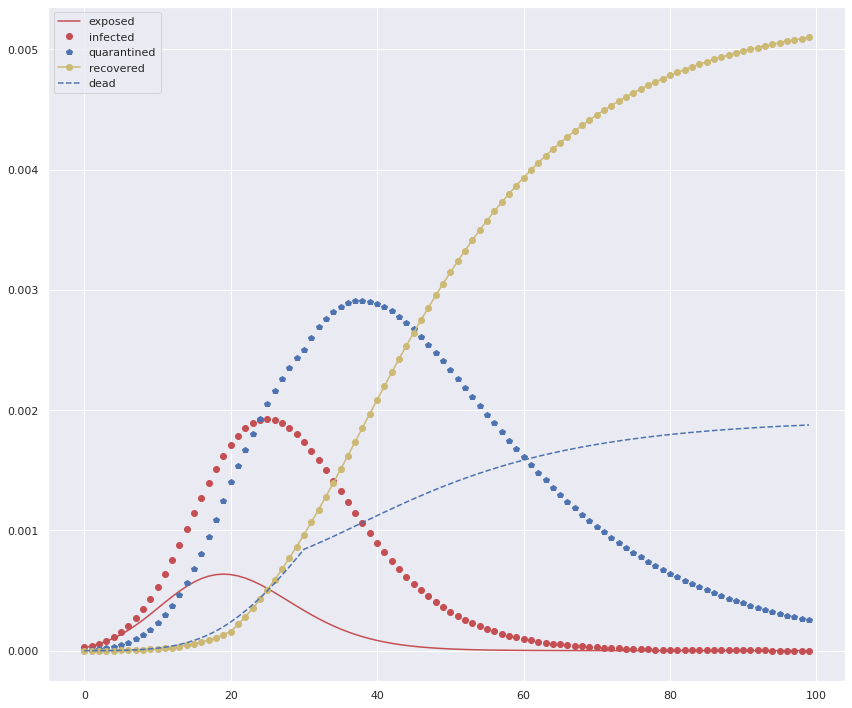

In [43]:
model.eval(1)
model.showParms()
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = model.solDF.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG007")

We modify $\beta$, to see if the optimization algorithm will be able to recover the correct value..

--  --  --  parms
beta	->	0.8
alpha	->	0.085
delta	->	0.13513513513513511
lamb	->	<function SEIRYModel.lambFn at 0x7f2be6535510>
kappa	->	<function SEIRYModel.kappaFn at 0x7f2be6535598>
gamma	->	0.5
--  --  --  --  --  --  


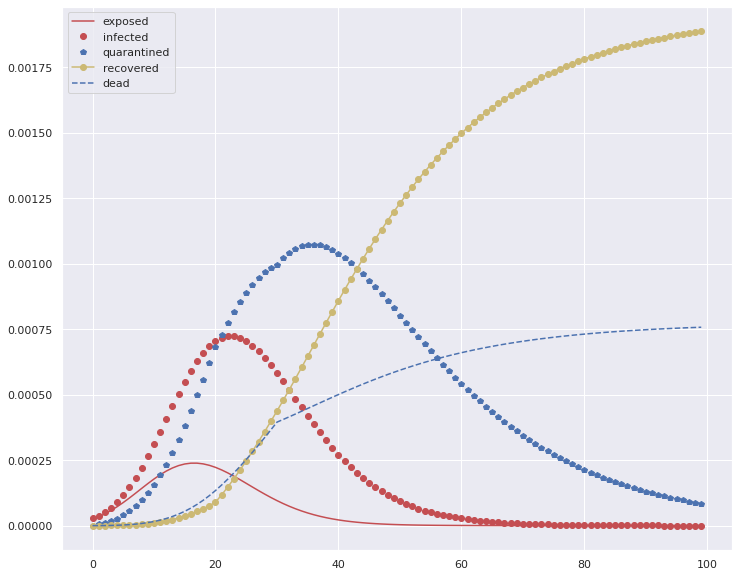

In [44]:
model.eval(0.8)
model.showParms()
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = model.solDF.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)

Saving figure FIG008


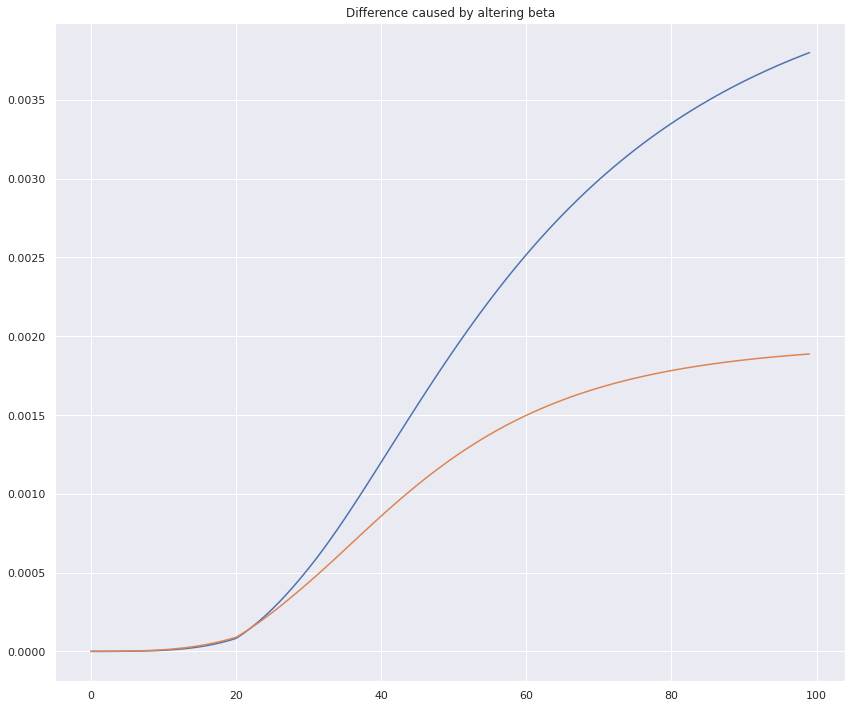

In [45]:
PLT.plot(t,recov)
PLT.plot(t,model.solDF.loc[:,"recovered"])
PLT.title("Difference caused by altering beta")
ImgMgr.save_fig("FIG008")

Now, let the optimisation function attempt to recover the correct value of $\beta$; with the 
modified beta the error (square) is:

In [46]:
initError=model.error(t,recov, "recovered")

In [47]:
def fun(beta, model, ref ):
    model.eval(beta)
    return model.error(t,ref, "recovered")

In [48]:
optResult=optimize.minimize(fun, 0.8, args=(model, recov), method='Nelder-Mead')

Now, optResult is an `OptimizeResult`object  as described on https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
and https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult

In [49]:
print( f"The optimization yields beta= {optResult.x[0]} correct is 1.0, residual error: {optResult.fun}")
print( f"The error has been reduced by a factor:{optResult.fun/initError}")

The optimization yields beta= 0.9203906250000004 correct is 1.0, residual error: 3.2824938607298765e-06
The error has been reduced by a factor:0.030997034068979436


### Effect of noise

Now we do the same procedure, but some noise has been added to the data ( in a weird fashion, since we are
representing a non decreasing quantity ... but this property is not respected....)

In [50]:
optResultRand=optimize.minimize(fun, 0.5, args=(model, recovRand), method='Nelder-Mead')

In [51]:
optResultRand

 final_simplex: (array([[0.92744141],
       [0.92753906]]), array([3.4269615e-06, 3.4270145e-06]))
           fun: 3.426961502812221e-06
       message: 'Optimization terminated successfully.'
          nfev: 30
           nit: 15
        status: 0
       success: True
             x: array([0.92744141])

In [52]:
print( f"The optimization yields beta= {optResultRand.x[0]} correct is 1.0, residual error: {optResultRand.fun}")

The optimization yields beta= 0.927441406250001 correct is 1.0, residual error: 3.426961502812221e-06


### Identifying multiple parameters


In [53]:
initParmDict= toDict( beta = 0.5,     # (default=1) rate of exposition (in prop of susceptibles
                                      #             meeting infected)
                 alpha = 0.085,       # (default=0.085) rate of susceptibles becoming insusceptible
                 delta = 1/2,        # (default=1/7.4 ) inverse average quarantine time
                 gamma = 0.25       # (default=1/2) inverse average latent time 
                    )
model = EPIM.SEIRYOpt2(initParmDict, t, recov)

In setInitial: initial values for ODE
	i0: infected	->	2.7785714285714285e-05
	e0: exposed	->	2.2714285714285713e-05
	r0: recovered	->	0
	q0: quarantined	->	0
	d0: dead	->	0
	p0: insusceptibles	->	0
	s0: susceptibles	->	0.9999495


--  --  --  parms
beta	->	0.5
alpha	->	0.085
delta	->	0.5
lamb	->	<function SEIRYModel.lambFn at 0x7f2be6535510>
kappa	->	<function SEIRYModel.kappaFn at 0x7f2be6535598>
gamma	->	0.25
--  --  --  --  --  --  


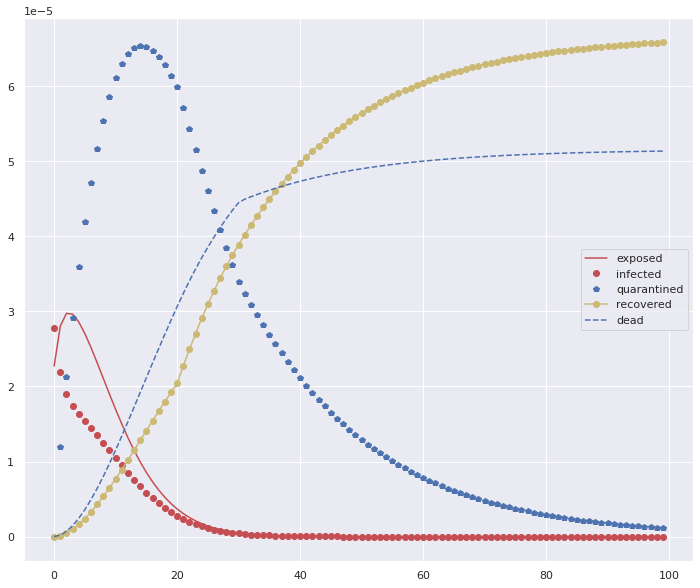

In [54]:
model.eval(None)
model.showParms()
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = model.solDF.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)

In [55]:
initError=model.error(t,recov, "recovered")
print(f"Initial error:{initError}")

Initial error:0.0004929421575535338


In [56]:
def fun(vals, model, ref ):
    model.eval(vals)
    return model.error(t,ref, "recovered")

In [57]:
optResult=optimize.minimize(fun,[1, 0.085, 0.5, 0.25] , args=(model, recov), method='Nelder-Mead')
optResult

 final_simplex: (array([[1.00743486, 0.09466665, 0.08379381, 0.32352085],
       [1.00743738, 0.09466703, 0.08379215, 0.32351918],
       [1.00738001, 0.0946636 , 0.08379631, 0.32354688],
       [1.00738118, 0.09466502, 0.08378961, 0.32354326],
       [1.00740711, 0.0946653 , 0.08379405, 0.3235336 ]]), array([9.03688238e-08, 9.03775521e-08, 9.04171765e-08, 9.04528829e-08,
       9.04623270e-08]))
           fun: 9.036882384701194e-08
       message: 'Optimization terminated successfully.'
          nfev: 393
           nit: 219
        status: 0
       success: True
             x: array([1.00743486, 0.09466665, 0.08379381, 0.32352085])

In [58]:
print( f"The optimization yields:")
for z in (("beta",0, 1), ("alpha",1,0.085),("delta",2,0.5), ("gamma",3,0.25) ):
    print (f"\t{z[0]}\tcalcul:{optResult.x[z[1]]}\tcorrect:{z[2]}\terr:{optResult.x[z[1]] - z[2]}")

The optimization yields:
	beta	calcul:1.007434863306459	correct:1	err:0.007434863306458928
	alpha	calcul:0.09466665465556626	correct:0.085	err:0.00966665465556625
	delta	calcul:0.08379381078264343	correct:0.5	err:-0.4162061892173566
	gamma	calcul:0.32352084878791265	correct:0.25	err:0.07352084878791265


Residual error from optimizer program:9.036882384701194e-08
Residual error verification:9.036882384701194e-08
--  --  --  parms
beta	->	1.007434863306459
alpha	->	0.09466665465556626
delta	->	0.08379381078264343
lamb	->	<function SEIRYModel.lambFn at 0x7f2be6535510>
kappa	->	<function SEIRYModel.kappaFn at 0x7f2be6535598>
gamma	->	0.32352084878791265
--  --  --  --  --  --  
Saving figure FIG009


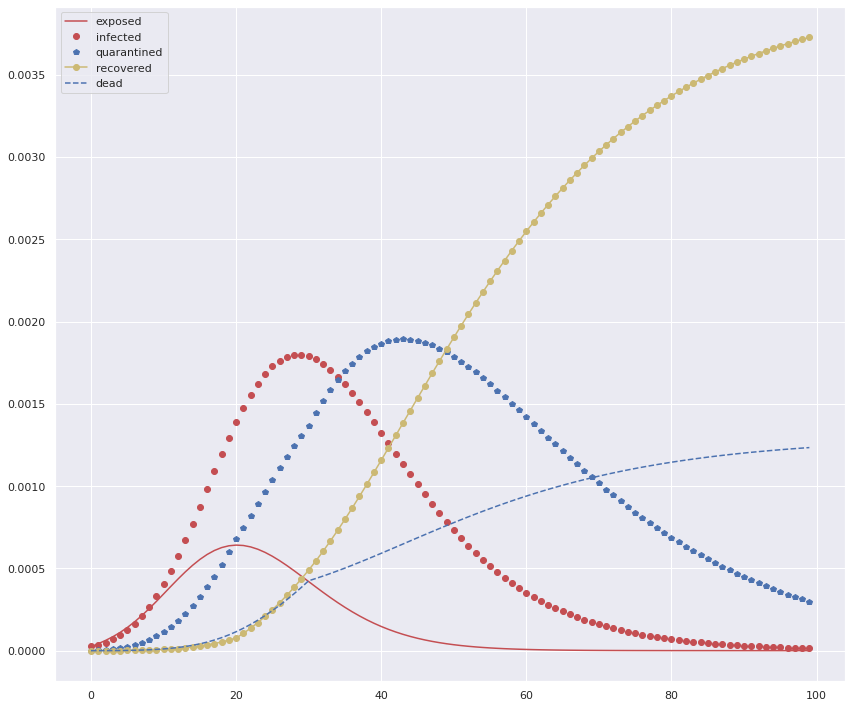

In [59]:
print(f"Residual error from optimizer program:{optResult.fun}")
# recompute the model with identified parameters
errVerif = model.eval(optResult.x)
print(f"Residual error verification:{errVerif}")
model.showParms()
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = model.solDF.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG009")

Saving figure FIG010


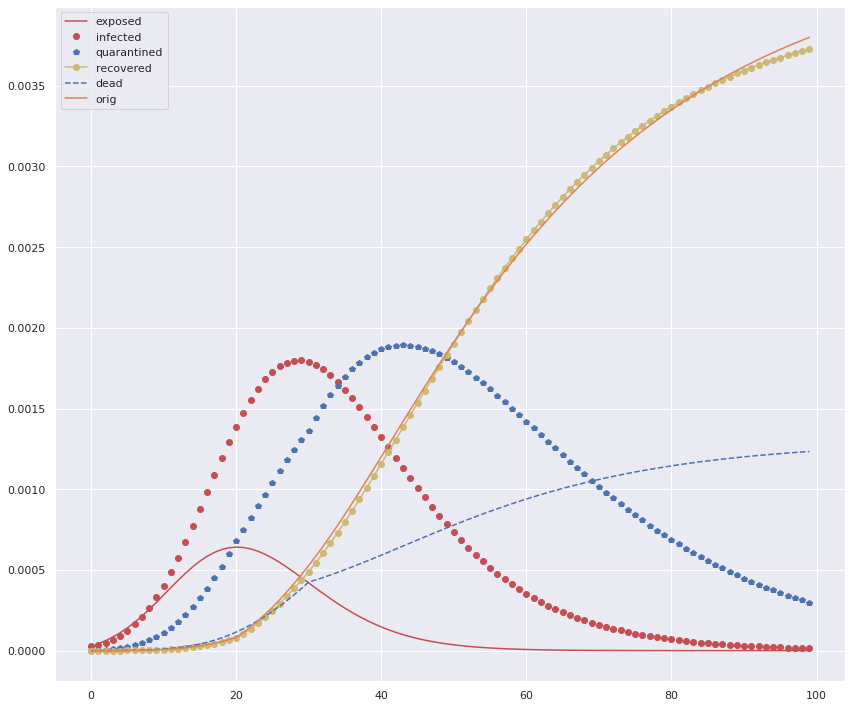

In [60]:
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
solCopy = model.solDF.loc[:,selCols].copy()
solCopy["orig"] = recov
selCols.append("orig")
ax = solCopy.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG010")

We redo it all with a noisy reference (target) solution.

In [61]:
optResultRand=optimize.minimize(fun,[0.5, 0.06, 0.3, 0.2] , args=(model, recovRand), method='Nelder-Mead')
optResultRand

 final_simplex: (array([[2.16940257, 0.0133647 , 1.42650821, 0.37175997],
       [2.16379672, 0.01346896, 1.41873382, 0.3702421 ],
       [2.18215354, 0.0136561 , 1.42485337, 0.36764501],
       [2.16796262, 0.01350773, 1.42008607, 0.36963348],
       [2.15136051, 0.0136899 , 1.40198088, 0.36707407]]), array([1.60898771e-07, 1.61310158e-07, 1.61615623e-07, 1.61819916e-07,
       1.62481196e-07]))
           fun: 1.6089877126673365e-07
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 800
           nit: 482
        status: 1
       success: False
             x: array([2.16940257, 0.0133647 , 1.42650821, 0.37175997])

In [62]:
print( f"The optimization yields:")
for z in (("beta",0, 1), ("alpha",1,0.085),("delta",2,0.5), ("gamma",3,0.25) ):
    print (f"\t{z[0]}\tcalcul:{optResultRand.x[z[1]]}\tcorrect:{z[2]}\terr:{optResultRand.x[z[1]] - z[2]}")

The optimization yields:
	beta	calcul:2.169402570472042	correct:1	err:1.1694025704720419
	alpha	calcul:0.013364699148333586	correct:0.085	err:-0.07163530085166642
	delta	calcul:1.426508210405887	correct:0.5	err:0.926508210405887
	gamma	calcul:0.37175996647888143	correct:0.25	err:0.12175996647888143


Residual error:1.6089877126673365e-07
--  --  --  parms
beta	->	2.169402570472042
alpha	->	0.013364699148333586
delta	->	1.426508210405887
lamb	->	<function SEIRYModel.lambFn at 0x7f2be6535510>
kappa	->	<function SEIRYModel.kappaFn at 0x7f2be6535598>
gamma	->	0.37175996647888143
--  --  --  --  --  --  
Saving figure FIG011


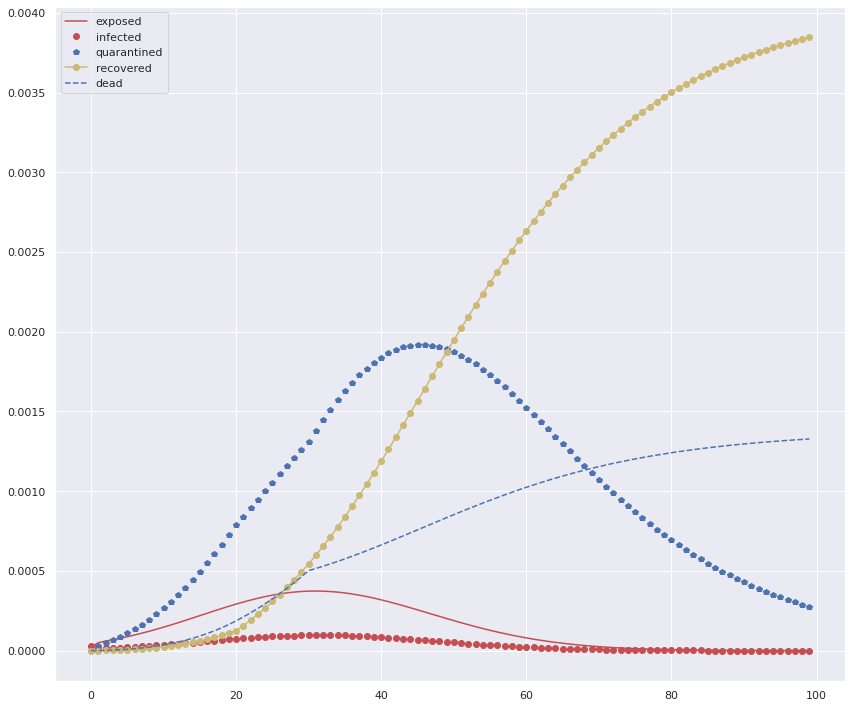

In [63]:
print(f"Residual error:{optResultRand.fun}")
# recompute the model with identified parameters
errVerif = model.eval(optResultRand.x)
model.showParms()
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = model.solDF.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG011")

Saving figure FIG012


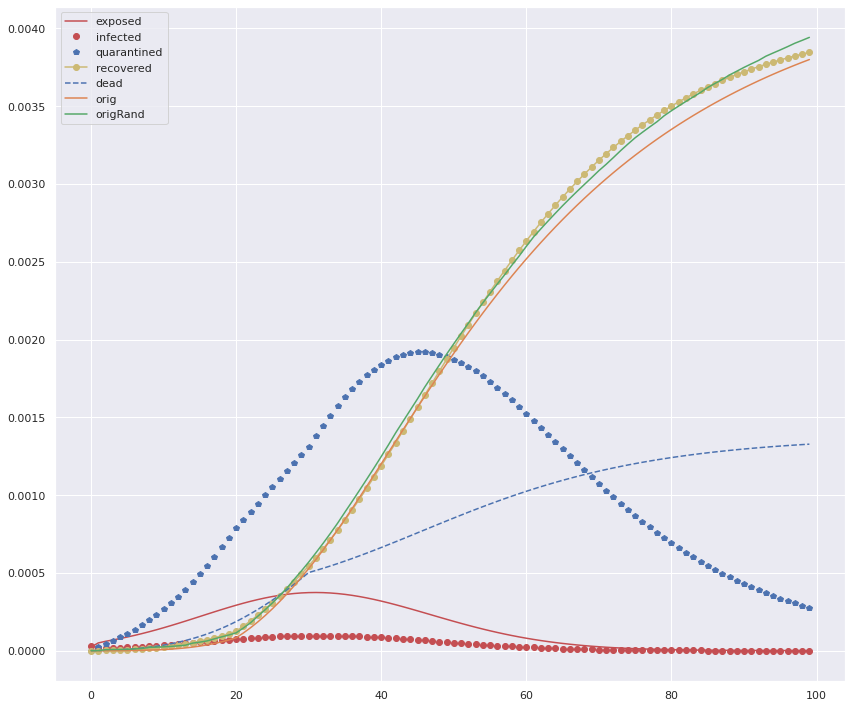

In [64]:
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
solCopy = model.solDF.loc[:,selCols].copy()
solCopy["orig"] = recov
solCopy["origRand"] = recovRand
selCols.append("orig")
selCols.append("origRand")
ax = solCopy.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG012")

We conclude that the curve is rather well fitted, but that we have not identified the parameters!

### Identifying multiple parameters, with multiple data curves

In [65]:
initParmDict= toDict( beta = 0.5,     # (default=1) rate of exposition (in prop of susceptibles
                                      #             meeting infected)
                 alpha = 0.06,       # (default=0.085) rate of susceptibles becoming insusceptible
                 delta = 0.3,        # (default=1/7.4 ) inverse average quarantine time
                 gamma = 0.2       # (default=1/2) inverse average latent time 
                    )
refDFY = PAN.DataFrame( data = {"recovered": recov, "dead":dead})

In [66]:
model = EPIM.SEIRYOpt3(initParmDict, t, refDFY)

In setInitial: initial values for ODE
	i0: infected	->	2.7785714285714285e-05
	e0: exposed	->	2.2714285714285713e-05
	r0: recovered	->	0
	q0: quarantined	->	0
	d0: dead	->	0
	p0: insusceptibles	->	0
	s0: susceptibles	->	0.9999495


--  --  --  parms
beta	->	0.5
alpha	->	0.06
delta	->	0.3
lamb	->	<function SEIRYModel.lambFn at 0x7f2be6535510>
kappa	->	<function SEIRYModel.kappaFn at 0x7f2be6535598>
gamma	->	0.2
--  --  --  --  --  --  
Saving figure FIG013


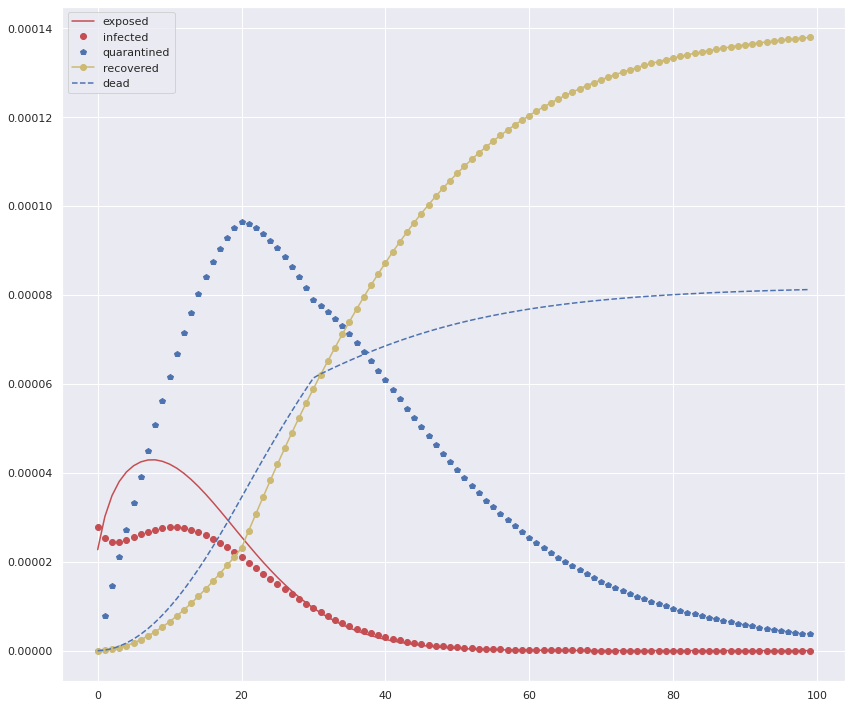

In [67]:
model.eval(None)
model.showParms()
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = model.solDF.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG013")

In [68]:
initError=model.error(t,refDFY)
print(f"Initial error:{initError}")

Initial error:0.0007267857836530875


In [69]:
def fun(vals, model, ref ):
    model.eval(vals)
    return model.error(t,ref)

optResult=optimize.minimize(fun,[0.5, 0.06, 0.3, 0.2] , args=(model, refDFY), method='Nelder-Mead')
optResult

 final_simplex: (array([[1.07297871e+03, 2.04125070e+02, 2.65524101e-02, 8.32822865e+03],
       [1.07297870e+03, 2.04125067e+02, 2.65524100e-02, 8.32822853e+03],
       [1.07297865e+03, 2.04125058e+02, 2.65524100e-02, 8.32822818e+03],
       [1.07297870e+03, 2.04125068e+02, 2.65524101e-02, 8.32822857e+03],
       [1.07297876e+03, 2.04125079e+02, 2.65524100e-02, 8.32822901e+03]]), array([2.55450691e-05, 2.55459388e-05, 2.55468855e-05, 2.55470629e-05,
       2.55473871e-05]))
           fun: 2.5545069140681394e-05
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 802
           nit: 451
        status: 1
       success: False
             x: array([1.07297871e+03, 2.04125070e+02, 2.65524101e-02, 8.32822865e+03])

The optimization yields:
	beta	calcul:1072.978711284697	correct:1	err:1071.978711284697
	alpha	calcul:204.12506995769786	correct:0.085	err:204.04006995769785
	delta	calcul:0.026552410070064075	correct:0.5	err:-0.4734475899299359
	gamma	calcul:8328.228649942346	correct:0.25	err:8327.978649942346
Residual error from optimizer program:2.5545069140681394e-05
Residual error verification:2.5545069140681394e-05
--  --  --  parms
beta	->	1072.978711284697
alpha	->	204.12506995769786
delta	->	0.026552410070064075
lamb	->	<function SEIRYModel.lambFn at 0x7f2be6535510>
kappa	->	<function SEIRYModel.kappaFn at 0x7f2be6535598>
gamma	->	8328.228649942346
--  --  --  --  --  --  
Saving figure FIG014


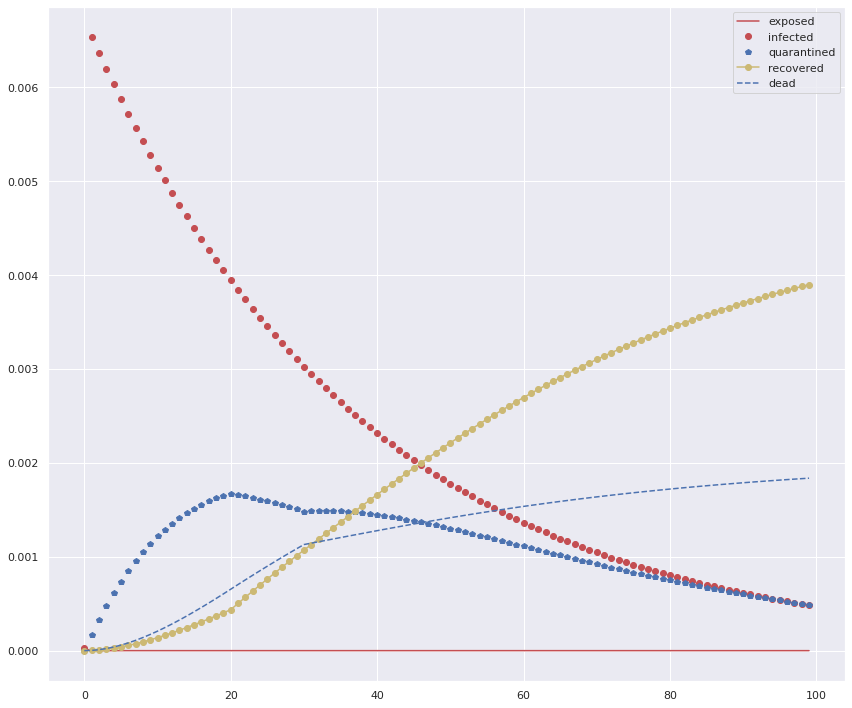

In [70]:
print( f"The optimization yields:")
for z in (("beta",0, 1), ("alpha",1,0.085),("delta",2,0.5), ("gamma",3,0.25) ):
    print (f"\t{z[0]}\tcalcul:{optResult.x[z[1]]}\tcorrect:{z[2]}\terr:{optResult.x[z[1]] - z[2]}")

print(f"Residual error from optimizer program:{optResult.fun}")
# recompute the model with identified parameters
errVerif = model.eval(optResult.x)
print(f"Residual error verification:{errVerif}")
model.showParms()
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = model.solDF.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG014")

Saving figure FIG015


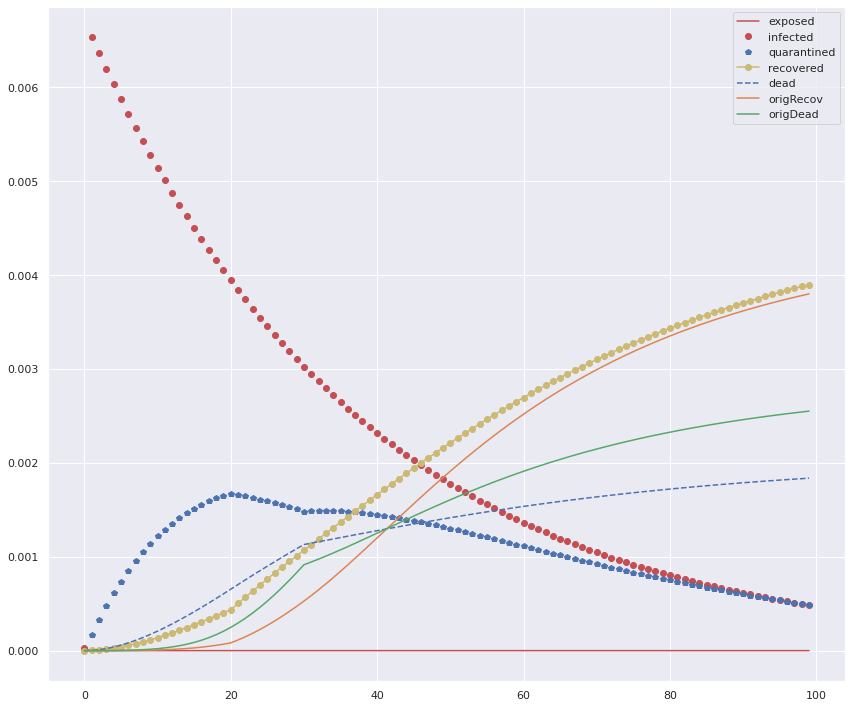

In [71]:
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
solCopy = model.solDF.loc[:,selCols].copy()
solCopy[ ["origRecov","origDead"] ] = refDFY
selCols.append("origRecov")
selCols.append("origDead")
ax = solCopy.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG015")

### We redo it all with a noisy reference (target) solution.

In [72]:
refDFYRand = PAN.DataFrame( data = {"recovered": recovRand, "dead":deadRand})

In [73]:
optResultRand=optimize.minimize(fun,[0.5, 0.06, 0.3, 0.2] , args=(model, refDFYRand), method='Nelder-Mead')
optResultRand

 final_simplex: (array([[0.86877169, 0.05891119, 0.30884155, 1.64053897],
       [0.8687746 , 0.0589114 , 0.3088395 , 1.64054475],
       [0.86878919, 0.05891243, 0.30885   , 1.64062608],
       [0.86878398, 0.05891309, 0.30883674, 1.64052288],
       [0.86878916, 0.05891278, 0.3088461 , 1.64059978]]), array([4.29908628e-05, 4.29917077e-05, 4.29935541e-05, 4.29938306e-05,
       4.29939477e-05]))
           fun: 4.29908627970906e-05
       message: 'Optimization terminated successfully.'
          nfev: 288
           nit: 157
        status: 0
       success: True
             x: array([0.86877169, 0.05891119, 0.30884155, 1.64053897])

The optimization yields:
	beta	calcul:0.8687716917848198	correct:1	err:-0.13122830821518017
	alpha	calcul:0.05891119021815505	correct:0.085	err:-0.026088809781844954
	delta	calcul:0.3088415488045879	correct:0.5	err:-0.19115845119541208
	gamma	calcul:1.6405389743806278	correct:0.25	err:1.3905389743806278
Residual error:4.29908627970906e-05
--  --  --  parms
beta	->	0.8687716917848198
alpha	->	0.05891119021815505
delta	->	0.3088415488045879
lamb	->	<function SEIRYModel.lambFn at 0x7f2be6535510>
kappa	->	<function SEIRYModel.kappaFn at 0x7f2be6535598>
gamma	->	1.6405389743806278
--  --  --  --  --  --  
Saving figure FIG016


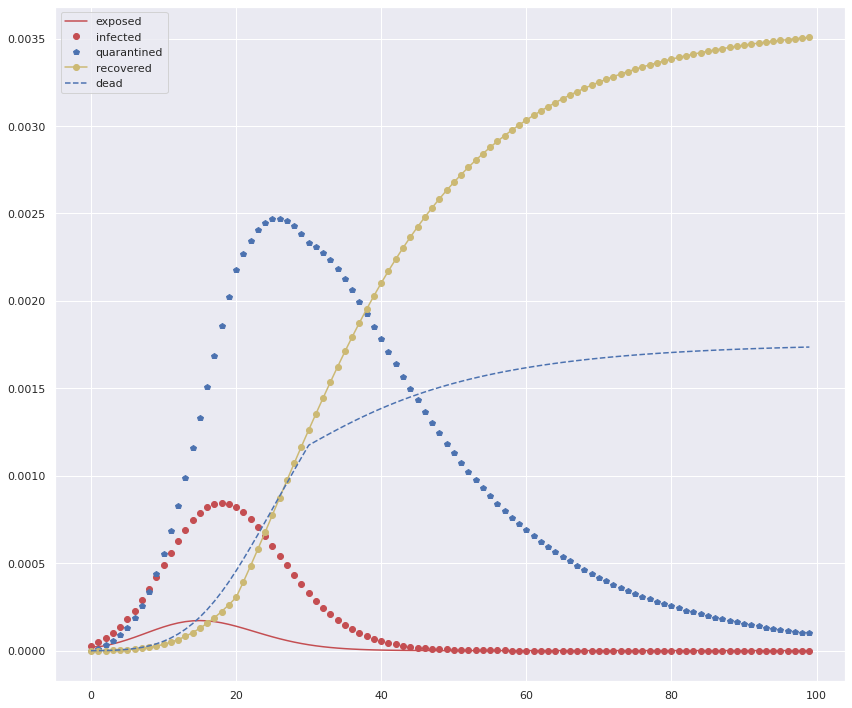

In [74]:
print( f"The optimization yields:")
for z in (("beta",0, 1), ("alpha",1,0.085),("delta",2,0.5), ("gamma",3,0.25) ):
    print (f"\t{z[0]}\tcalcul:{optResultRand.x[z[1]]}\tcorrect:{z[2]}\terr:{optResultRand.x[z[1]] - z[2]}")

print(f"Residual error:{optResultRand.fun}")
# recompute the model with identified parameters
errVerif = model.eval(optResultRand.x)
model.showParms()
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = model.solDF.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG016")

Saving figure FIG017


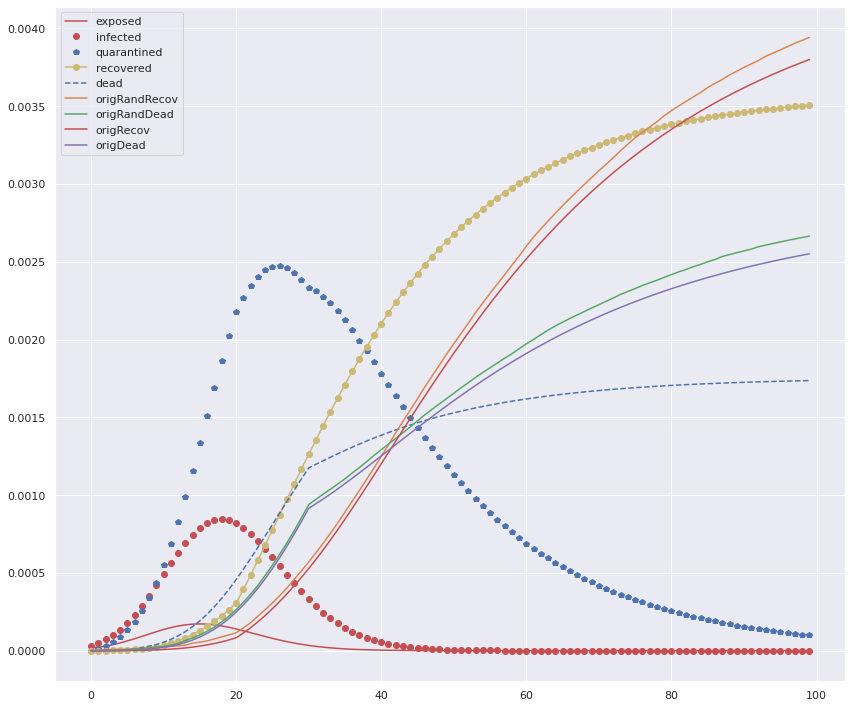

In [75]:
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
solCopy = model.solDF.loc[:,selCols].copy()
solCopy[ ["origRecov","origDead"] ] = refDFY
solCopy[ ["origRandRecov","origRandDead"] ] = refDFYRand
selCols.append("origRandRecov")
selCols.append("origRandDead")
selCols.append("origRecov")
selCols.append("origDead")
ax = solCopy.loc[:,selCols].plot(style=styles)
PLT.legend(labels=selCols)
ImgMgr.save_fig("FIG017")

On this example the parameters are poorly recovered, curve fitting not spectacular. Need to better understand the reasons..... **So, there is little chance to recover parameters this way!!** 

However things work much better when using real data on file:FIT-Data-FromGouv.ipynb .